### 5. Рекуррентные нейронные сети
Попробуйте изменить параметры нейронной сети, работающей с датасетом imdb, либо нейронной сети, работающей airline-passengers (она прилагается вместе с датасетом к уроку в виде отдельного скрипта) так, чтобы улучшить её точность.Приложите анализ

Попробуйте изменить параметры нейронной сети, генерирующей текст таким образом, чтобы добиться генерации как можно более осмысленного текста. Пришлите лучший текст из получившихся и опишите предпринятые для его получения действия. Можно использовать текст другого произведения

Попробуйте реализовать нейронную сеть архитектуры LSTM на numpy

Предложите свои варианты решения проблемы исчезающего градиента в RNN

In [1]:
import tensorflow as tf

from tensorflow.keras import layers

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing import timeseries_dataset_from_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv1D, Flatten


In [3]:
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU

In [4]:
tf.random.set_seed(1)

In [5]:
tf.config.list_physical_devices('GPU')

[]

In [6]:
airline_passengers_data = pd.read_csv('airline-passengers.csv')

In [7]:
airline_passengers_data.head(5)

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [8]:
airline_passengers_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [9]:
airline_passengers_data['Month'].value_counts()

1949-01    1
1949-02    1
1956-09    1
1956-10    1
1956-11    1
          ..
1953-01    1
1953-02    1
1953-03    1
1953-04    1
1960-12    1
Name: Month, Length: 144, dtype: int64

In [10]:
airline_passengers_data['Month'] = pd.to_datetime(airline_passengers_data['Month'], format='%Y-%m')

In [11]:
def parse_date(df, date_feature_name):
    date_list = df[date_feature_name]
    years = []
    months = []
    for el in date_list:
        years.append(el.year)
        months.append(el.month)
    df['year'] = years
    df['mon'] = months

    return df

In [12]:
airline_passengers_data = parse_date(airline_passengers_data, 'Month')

In [13]:
data = airline_passengers_data.iloc[:, 1:]
data.head()

,Passengers,year,mon
0,112,1949,1
1,118,1949,2
2,132,1949,3
3,129,1949,4
4,121,1949,5


Преобразованные таким образом данные разбиваем на тест и трейн

In [14]:
train_size = 100
# наши фичи
features = ['Passengers', 'year', 'mon']
# отступ теста от трейна
bias = 5

train_data = data.iloc[:train_size][features]
val_data = data.iloc[train_size + bias:][features]

train_data.shape, val_data.shape

((100, 3), (39, 3))

In [15]:
#данные для обучения
features = train_data.columns[1:]
target = train_data.columns[0]

In [16]:
scaler = StandardScaler()

train_data[features] = scaler.fit_transform(train_data[features])
val_data[features] = scaler.transform(val_data[features])

train_data.head()

,Passengers,year,mon
0,112,-1.525724,-1.534863
1,118,-1.525724,-1.247435
2,132,-1.525724,-0.960008
3,129,-1.525724,-0.672580
4,121,-1.525724,-0.385153


Формируем параметры для генерации выборки

In [17]:
# длина выборки
x_len = 3
# горизонт предсказания
future = 1
# параметры модели для обучения
learning_rate = 0.001
batch_size = 8
epochs = 10

In [18]:
start = x_len + future
end = start + train_size

print(start, end)

X_train = train_data[features].values
y_train = data.iloc[start:end][target].values


x_end = len(val_data) - x_len - future
label_start = len(train_data) + bias + x_len + future
print(x_end, label_start)

X_val = val_data.iloc[:x_end][features].values
y_val = data.iloc[label_start:][target].values

4 104
35 109


In [19]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((100, 2), (100,), (35, 2), (35,))

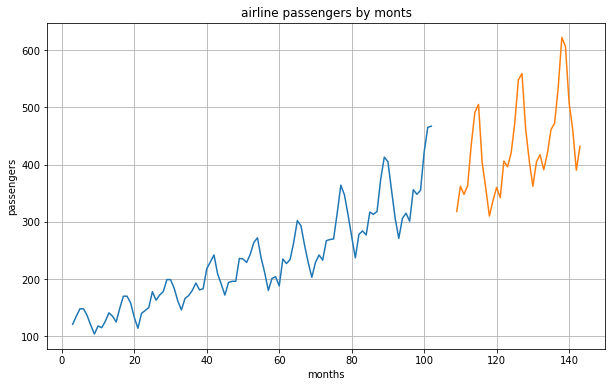

In [20]:
plt.figure(figsize=(10, 6))
plt.plot(data.index[x_len:y_train.shape[0]+x_len],y_train[:])
plt.plot(data.index[y_train.shape[0]+x_len+bias+future:],y_val[:])
plt.grid('on')
plt.xlabel('months')
plt.ylabel('passengers')
plt.title('airline passengers by monts')
plt.show()

In [21]:
dataset_train = timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

dataset_val = timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=x_len,
    sampling_rate=1,
    batch_size=batch_size,
)

In [22]:
for batch in dataset_train.take(1):
    inputs, targets = batch
    print("Input shape:", inputs.shape)
    print(inputs[1])
    print("Target shape:", targets.shape)
    print(targets[1])

Input shape: (8, 3, 2)
tf.Tensor(
[[-1.52572369 -1.24743549]
 [-1.52572369 -0.96000796]
 [-1.52572369 -0.67258043]], shape=(3, 2), dtype=float64)
Target shape: (8,)
tf.Tensor(135, shape=(), dtype=int64)


In [23]:
results = pd.DataFrame() # сводная таблица результатов
model = [] # шаг
train_m = [] # результат на трейне
test_m = [] # результат на тесте

#### Создадим простую сеть SimpleRNN

In [24]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_1 = Sequential()

model_1.add(SimpleRNN(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_1.add(Conv1D(64, 3, activation='linear'))
model_1.add(Conv1D(64, 1, activation='linear'))
model_1.add(Flatten())
model_1.add(Dense(3, activation='linear'))
model_1.add(Dense(1, activation='linear'))

model_1.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 3, 32)             1120      
                                                                 
 conv1d (Conv1D)             (None, 1, 64)             6208      
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 3)                 195       
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 11,687
Trainable params: 11,687
Non-traina

In [25]:
#обучение нашей сети SimpleRNN
history_1 = model_1.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 5s 76ms/step - loss: 57094.9023 - mae: 226.1811 - val_loss: 195624.2031 - val_mae: 434.9742
Epoch 2/10
13/13 [==============================] - 0s 20ms/step - loss: 56513.7148 - mae: 224.9959 - val_loss: 193387.8750 - val_mae: 432.4574
Epoch 3/10
13/13 [==============================] - 0s 21ms/step - loss: 56245.7461 - mae: 224.7482 - val_loss: 191218.2500 - val_mae: 430.0117
Epoch 4/10
13/13 [==============================] - 0s 20ms/step - loss: 55768.1367 - mae: 224.1167 - val_loss: 187580.7656 - val_mae: 425.8792
Epoch 5/10
13/13 [==============================] - 0s 20ms/step - loss: 54652.0977 - mae: 222.4545 - val_loss: 179834.9531 - val_mae: 416.9126
Epoch 6/10
13/13 [==============================] - 0s 20ms/step - loss: 51894.8125 - mae: 217.9654 - val_loss: 162893.9688 - val_mae: 396.5047
Epoch 7/10
13/13 [==============================] - 0s 20ms/step - loss: 45368.4805 - mae: 205.8743 - val_loss: 128987.3359 - val_mae: 3

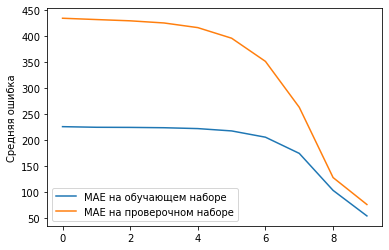

In [26]:
#посмотрим на график метрик обучения
plt.plot(history_1.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_1.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [27]:
hist_val_1 = history_1.history['val_mae']
hist_train_1 = history_1.history['mae']

In [28]:
#увеличим кол-во итераций
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 0s 20ms/step - loss: 2111.0098 - mae: 37.8554 - val_loss: 17510.7305 - val_mae: 111.1810
Epoch 2/10
13/13 [==============================] - 0s 20ms/step - loss: 1308.4910 - mae: 27.5004 - val_loss: 15955.6670 - val_mae: 105.3012
Epoch 3/10
13/13 [==============================] - 0s 20ms/step - loss: 1288.5428 - mae: 28.2981 - val_loss: 12613.4805 - val_mae: 90.4579
Epoch 4/10
13/13 [==============================] - 0s 20ms/step - loss: 1291.9678 - mae: 28.5157 - val_loss: 12854.2178 - val_mae: 92.3002
Epoch 5/10
13/13 [==============================] - 0s 20ms/step - loss: 1194.9994 - mae: 27.2652 - val_loss: 12896.3281 - val_mae: 92.8590
Epoch 6/10
13/13 [==============================] - 0s 20ms/step - loss: 1138.4083 - mae: 26.5488 - val_loss: 12272.3604 - val_mae: 89.9709
Epoch 7/10
13/13 [==============================] - 0s 20ms/step - loss: 1092.4316 - mae: 25.9846 - val_loss: 11892.0840 - val_mae: 88.3121
Epoch 8/10
13/13 [

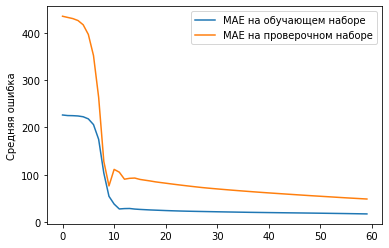

Epoch 1/10
13/13 [==============================] - 0s 20ms/step - loss: 448.5579 - mae: 16.8444 - val_loss: 3943.5994 - val_mae: 47.9864
Epoch 2/10
13/13 [==============================] - 0s 19ms/step - loss: 438.2458 - mae: 16.6500 - val_loss: 3838.9780 - val_mae: 47.4235
Epoch 3/10
13/13 [==============================] - 0s 21ms/step - loss: 427.7367 - mae: 16.4452 - val_loss: 3735.2791 - val_mae: 46.8526
Epoch 4/10
13/13 [==============================] - 0s 20ms/step - loss: 417.0432 - mae: 16.2297 - val_loss: 3632.5977 - val_mae: 46.2732
Epoch 5/10
13/13 [==============================] - 0s 20ms/step - loss: 406.1800 - mae: 16.0112 - val_loss: 3531.0686 - val_mae: 45.6851
Epoch 6/10
13/13 [==============================] - 0s 20ms/step - loss: 395.1757 - mae: 15.8048 - val_loss: 3430.8242 - val_mae: 45.0880
Epoch 7/10
13/13 [==============================] - 0s 20ms/step - loss: 384.0592 - mae: 15.5897 - val_loss: 3332.0286 - val_mae: 44.4820
Epoch 8/10
13/13 [================

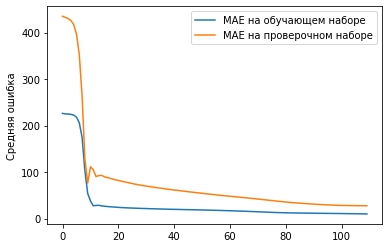

Epoch 1/10
13/13 [==============================] - 0s 20ms/step - loss: 143.4181 - mae: 9.9593 - val_loss: 1363.6326 - val_mae: 27.5098
Epoch 2/10
13/13 [==============================] - 0s 20ms/step - loss: 141.0732 - mae: 9.8716 - val_loss: 1352.1382 - val_mae: 27.4465
Epoch 3/10
13/13 [==============================] - 0s 19ms/step - loss: 138.7702 - mae: 9.7885 - val_loss: 1340.9517 - val_mae: 27.3825
Epoch 4/10
13/13 [==============================] - 0s 20ms/step - loss: 136.5334 - mae: 9.7090 - val_loss: 1330.2539 - val_mae: 27.3180
Epoch 5/10
13/13 [==============================] - 0s 20ms/step - loss: 134.3442 - mae: 9.6273 - val_loss: 1319.8231 - val_mae: 27.2526
Epoch 6/10
13/13 [==============================] - 0s 20ms/step - loss: 132.2297 - mae: 9.5463 - val_loss: 1309.8383 - val_mae: 27.1864
Epoch 7/10
13/13 [==============================] - 0s 20ms/step - loss: 130.1685 - mae: 9.4635 - val_loss: 1300.1010 - val_mae: 27.1191
Epoch 8/10
13/13 [=======================

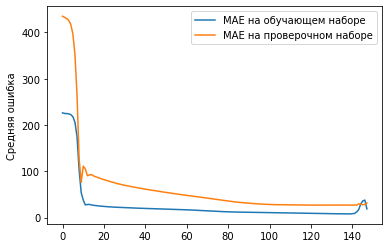

Epoch 1/10
13/13 [==============================] - 0s 20ms/step - loss: 333.2861 - mae: 13.9751 - val_loss: 1498.7352 - val_mae: 28.2001
Epoch 2/10
13/13 [==============================] - 0s 20ms/step - loss: 420.0847 - mae: 17.7084 - val_loss: 1400.1191 - val_mae: 28.0746
Epoch 3/10
13/13 [==============================] - 0s 20ms/step - loss: 368.3170 - mae: 16.6005 - val_loss: 1680.8961 - val_mae: 29.8201
Epoch 4/10
13/13 [==============================] - 0s 20ms/step - loss: 278.9170 - mae: 14.4638 - val_loss: 1357.5587 - val_mae: 27.9019
Epoch 5/10
13/13 [==============================] - 0s 20ms/step - loss: 274.1895 - mae: 14.0367 - val_loss: 1562.1812 - val_mae: 28.7449
Epoch 6/10
13/13 [==============================] - 0s 20ms/step - loss: 232.3905 - mae: 13.1653 - val_loss: 1320.8815 - val_mae: 27.6769
Epoch 7/10
13/13 [==============================] - 0s 20ms/step - loss: 229.4465 - mae: 12.7933 - val_loss: 1476.7106 - val_mae: 28.1319
Epoch 8/10
13/13 [================

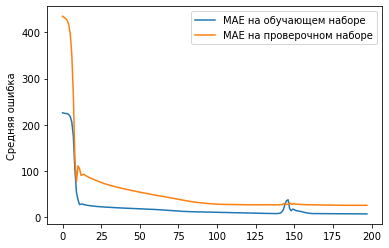

Epoch 1/10
13/13 [==============================] - 0s 22ms/step - loss: 85.2341 - mae: 7.3131 - val_loss: 1039.9149 - val_mae: 25.9113
Epoch 2/10
13/13 [==============================] - 0s 25ms/step - loss: 84.8929 - mae: 7.2461 - val_loss: 1034.6865 - val_mae: 25.8285
Epoch 3/10
13/13 [==============================] - 0s 24ms/step - loss: 84.5616 - mae: 7.2621 - val_loss: 1038.6664 - val_mae: 25.9421
Epoch 4/10
13/13 [==============================] - 0s 21ms/step - loss: 84.3084 - mae: 7.2540 - val_loss: 1030.3455 - val_mae: 25.7922
Epoch 5/10
13/13 [==============================] - 0s 20ms/step - loss: 84.3300 - mae: 7.2288 - val_loss: 1034.2758 - val_mae: 25.9062
Epoch 6/10
13/13 [==============================] - 0s 20ms/step - loss: 84.4296 - mae: 7.2837 - val_loss: 1030.1113 - val_mae: 25.8331
Epoch 7/10
13/13 [==============================] - 0s 20ms/step - loss: 84.4396 - mae: 7.2131 - val_loss: 1026.6420 - val_mae: 25.7988
Epoch 8/10
13/13 [==============================

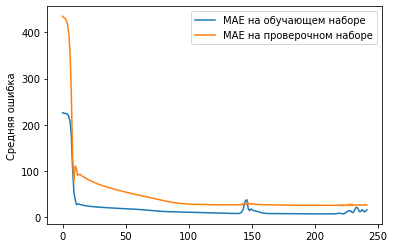

In [29]:
for iteration in range(num_iterations):
  history_1 = model_1.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_1.extend(history_1.history['val_mae'][:])
  hist_train_1.extend(history_1.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_1, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_1, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

Проверяем результаты

In [30]:
pred_1 = model_1.predict(dataset_train).flatten()
pred_val_1 = model_1.predict(dataset_val).flatten()

5/5 [==============================] - 0s 4ms/step


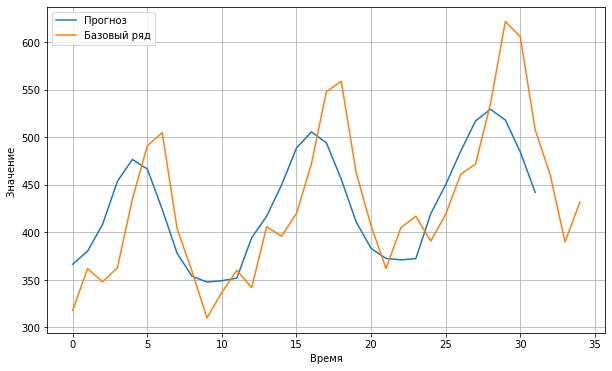

In [31]:
start = 0
step = 100
plt.figure(figsize=(10, 6))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

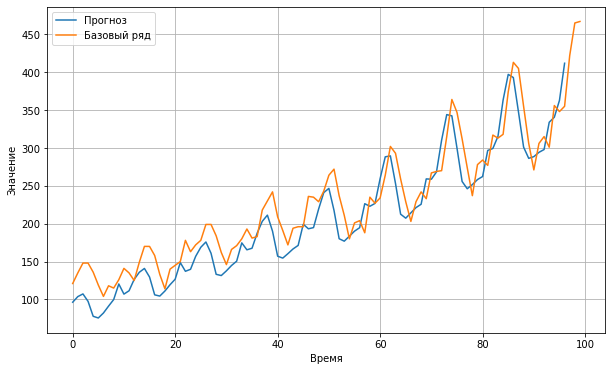

In [32]:
start = 0

plt.figure(figsize=(10, 6))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [33]:
train_loss_1, train_m_1 = model_1.evaluate(dataset_train)
test_loss_1, test_m_1 = model_1.evaluate(dataset_val)
print(f'train_loss: {train_loss_1}, train_m: {train_m_1}')
print(f'test_loss: {test_loss_1}, test_m: {test_m_1}')

model.append('SimpleRNN')
train_m.append(round(train_m_1,2))
test_m.append(round(test_m_1,2))

5/5 [==============================] - 0s 5ms/step - loss: 1142.9526 - mae: 25.9866
train_loss: 528.4807739257812, train_m: 20.292604446411133
test_loss: 1142.95263671875, test_m: 25.986560821533203


#### Создадим сеть LSTM

In [34]:
early_stop = EarlyStopping(monitor='val_mae', patience=5)

model_2 = Sequential()

model_2.add(LSTM(32, input_shape=(inputs.shape[1], inputs.shape[2]),
               return_sequences=True))
model_2.add(LSTM(32, return_sequences=True))
model_2.add(Conv1D(64, 3, activation='linear'))
model_2.add(Conv1D(64, 1, activation='linear'))
model_2.add(Flatten())
model_2.add(Dense(3, activation='linear'))
model_2.add(Dense(1, activation='linear'))

model_2.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3, 32)             4480      
                                                                 
 lstm_1 (LSTM)               (None, 3, 32)             8320      
                                                                 
 conv1d_2 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
 dense_3 (Dense)             (None, 1)                

In [35]:
#обучение сети
history_2 = model_2.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 12s 190ms/step - loss: 56601.8047 - mae: 225.5294 - val_loss: 192905.6719 - val_mae: 431.8859
Epoch 2/10
13/13 [==============================] - 0s 26ms/step - loss: 56038.0508 - mae: 224.3401 - val_loss: 191236.4531 - val_mae: 429.9663
Epoch 3/10
13/13 [==============================] - 0s 26ms/step - loss: 54349.5625 - mae: 220.8934 - val_loss: 185324.3438 - val_mae: 423.1163
Epoch 4/10
13/13 [==============================] - 0s 26ms/step - loss: 48545.6953 - mae: 208.7514 - val_loss: 163410.7969 - val_mae: 396.7852
Epoch 5/10
13/13 [==============================] - 0s 26ms/step - loss: 31344.8496 - mae: 167.9113 - val_loss: 95652.8438 - val_mae: 301.4149
Epoch 6/10
13/13 [==============================] - 0s 32ms/step - loss: 3893.4243 - mae: 54.8177 - val_loss: 7503.9966 - val_mae: 71.2311
Epoch 7/10
13/13 [==============================] - 0s 33ms/step - loss: 5599.4194 - mae: 60.0191 - val_loss: 5371.1138 - val_mae: 55.1704
E

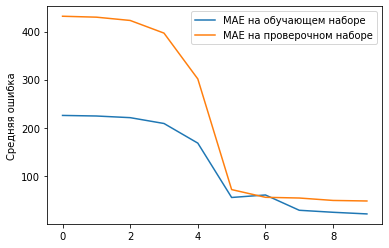

In [36]:
#посмотрим график метрик обучения
plt.plot(history_2.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_2.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [37]:
hist_val_2 = history_2.history['val_mae']
hist_train_2 = history_2.history['mae']

In [38]:
num_iterations = 25

Epoch 1/10
13/13 [==============================] - 0s 34ms/step - loss: 675.6352 - mae: 20.4642 - val_loss: 3781.9771 - val_mae: 45.5757
Epoch 2/10
13/13 [==============================] - 0s 33ms/step - loss: 655.9045 - mae: 19.9619 - val_loss: 3835.0906 - val_mae: 45.5647
Epoch 3/10
13/13 [==============================] - 0s 31ms/step - loss: 651.1599 - mae: 19.9330 - val_loss: 3705.0662 - val_mae: 44.9739
Epoch 4/10
13/13 [==============================] - 0s 31ms/step - loss: 648.0260 - mae: 19.8628 - val_loss: 3650.1230 - val_mae: 44.7233
Epoch 5/10
13/13 [==============================] - 0s 27ms/step - loss: 643.8818 - mae: 19.7578 - val_loss: 3606.8884 - val_mae: 44.5218
Epoch 6/10
13/13 [==============================] - 0s 27ms/step - loss: 640.4211 - mae: 19.6723 - val_loss: 3556.6326 - val_mae: 44.2874
Epoch 7/10
13/13 [==============================] - 0s 27ms/step - loss: 636.8979 - mae: 19.6030 - val_loss: 3517.0527 - val_mae: 44.0883
Epoch 8/10
13/13 [================

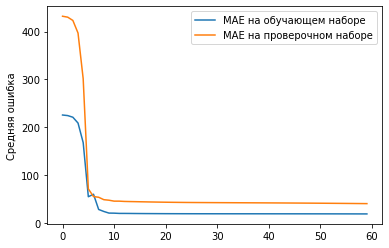

Epoch 1/10
13/13 [==============================] - 0s 27ms/step - loss: 572.3051 - mae: 18.8760 - val_loss: 2743.3184 - val_mae: 40.2876
Epoch 2/10
13/13 [==============================] - 0s 26ms/step - loss: 570.4033 - mae: 18.8551 - val_loss: 2729.3582 - val_mae: 40.2125
Epoch 3/10
13/13 [==============================] - 0s 27ms/step - loss: 568.4318 - mae: 18.8323 - val_loss: 2715.3850 - val_mae: 40.1338
Epoch 4/10
13/13 [==============================] - 0s 26ms/step - loss: 566.3853 - mae: 18.8073 - val_loss: 2701.3979 - val_mae: 40.0515
Epoch 5/10
13/13 [==============================] - 0s 27ms/step - loss: 564.2559 - mae: 18.7800 - val_loss: 2687.3789 - val_mae: 39.9652
Epoch 6/10
13/13 [==============================] - 0s 28ms/step - loss: 562.0383 - mae: 18.7504 - val_loss: 2673.3145 - val_mae: 39.8748
Epoch 7/10
13/13 [==============================] - 0s 27ms/step - loss: 559.7245 - mae: 18.7183 - val_loss: 2659.1870 - val_mae: 39.7800
Epoch 8/10
13/13 [================

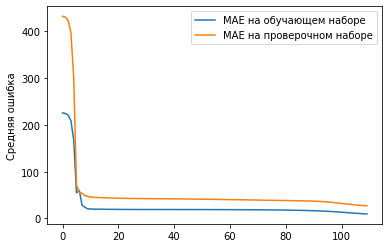

Epoch 1/10
13/13 [==============================] - 0s 29ms/step - loss: 150.7235 - mae: 9.5689 - val_loss: 1030.9510 - val_mae: 26.6879
Epoch 2/10
13/13 [==============================] - 0s 27ms/step - loss: 147.0270 - mae: 9.4091 - val_loss: 1009.4066 - val_mae: 26.3916
Epoch 3/10
13/13 [==============================] - 0s 27ms/step - loss: 144.2980 - mae: 9.3020 - val_loss: 991.9119 - val_mae: 26.1388
Epoch 4/10
13/13 [==============================] - 0s 26ms/step - loss: 142.2967 - mae: 9.2232 - val_loss: 977.7993 - val_mae: 25.9506
Epoch 5/10
13/13 [==============================] - 0s 27ms/step - loss: 140.8173 - mae: 9.1636 - val_loss: 966.4756 - val_mae: 25.8311
Epoch 6/10
13/13 [==============================] - 0s 26ms/step - loss: 139.6941 - mae: 9.1175 - val_loss: 957.5820 - val_mae: 25.7373
Epoch 7/10
13/13 [==============================] - 0s 26ms/step - loss: 138.8143 - mae: 9.0806 - val_loss: 950.7751 - val_mae: 25.6678
Epoch 8/10
13/13 [============================

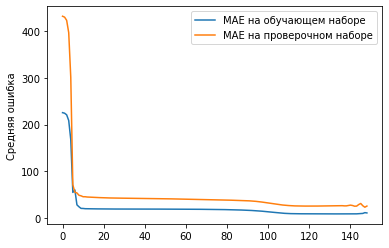

Epoch 1/10
13/13 [==============================] - 0s 27ms/step - loss: 340.2296 - mae: 15.3314 - val_loss: 2174.9700 - val_mae: 42.0990
Epoch 2/10
13/13 [==============================] - 0s 27ms/step - loss: 288.0827 - mae: 14.1215 - val_loss: 1435.8145 - val_mae: 32.6193
Epoch 3/10
13/13 [==============================] - 0s 27ms/step - loss: 653.2963 - mae: 22.2246 - val_loss: 774.6459 - val_mae: 22.2432
Epoch 4/10
13/13 [==============================] - 0s 27ms/step - loss: 411.1465 - mae: 17.1474 - val_loss: 1338.6776 - val_mae: 31.3129
Epoch 5/10
13/13 [==============================] - 0s 27ms/step - loss: 805.5165 - mae: 23.8528 - val_loss: 2497.7905 - val_mae: 44.9222
Epoch 6/10
13/13 [==============================] - 0s 27ms/step - loss: 674.4344 - mae: 20.6220 - val_loss: 566.7988 - val_mae: 20.2820
Epoch 7/10
13/13 [==============================] - 0s 27ms/step - loss: 1491.1958 - mae: 33.4874 - val_loss: 1517.5646 - val_mae: 33.3735
Epoch 8/10
13/13 [=================

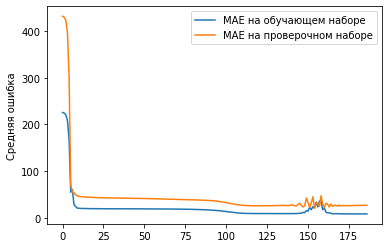

Epoch 1/10
13/13 [==============================] - 0s 27ms/step - loss: 116.5872 - mae: 8.2092 - val_loss: 995.8135 - val_mae: 26.8181
Epoch 2/10
13/13 [==============================] - 0s 27ms/step - loss: 116.6039 - mae: 8.2082 - val_loss: 999.7402 - val_mae: 26.8906
Epoch 3/10
13/13 [==============================] - 0s 27ms/step - loss: 116.5877 - mae: 8.2076 - val_loss: 1004.0255 - val_mae: 26.9681
Epoch 4/10
13/13 [==============================] - 0s 26ms/step - loss: 116.5781 - mae: 8.2064 - val_loss: 1007.1396 - val_mae: 27.0264
Epoch 5/10
13/13 [==============================] - 0s 27ms/step - loss: 116.5933 - mae: 8.2056 - val_loss: 1010.8508 - val_mae: 27.0929
Epoch 6/10
13/13 [==============================] - 0s 27ms/step - loss: 116.5835 - mae: 8.2052 - val_loss: 1015.1416 - val_mae: 27.1677
Epoch 1/10
13/13 [==============================] - 0s 26ms/step - loss: 116.5710 - mae: 8.2044 - val_loss: 1018.5732 - val_mae: 27.2285
Epoch 2/10
13/13 [=========================

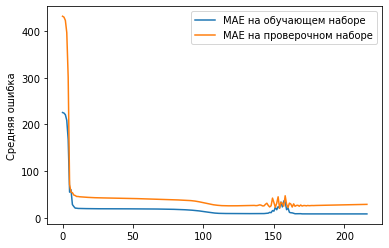

In [39]:
for iteration in range(num_iterations):
  history_2 = model_2.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_2.extend(history_2.history['val_mae'][:])
  hist_train_2.extend(history_2.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_2, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_2, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

Проверяем результаты

In [40]:
pred_2 = model_2.predict(dataset_train).flatten()
pred_val_2 = model_2.predict(dataset_val).flatten()

5/5 [==============================] - 0s 5ms/step


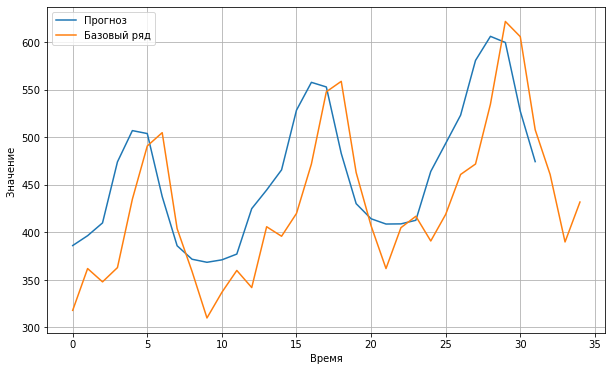

In [41]:
start = 0
step = 100
plt.figure(figsize=(10, 6))
plt.grid('on')
plt.plot(pred_val_2[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

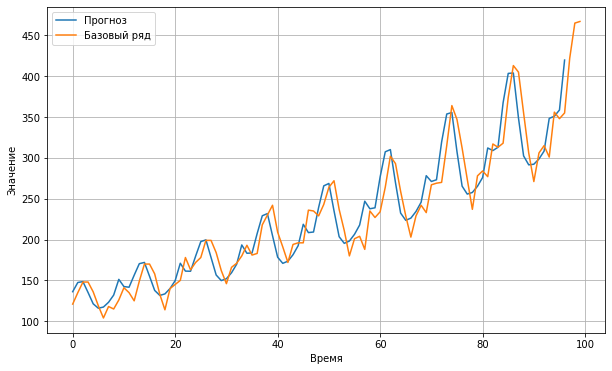

In [42]:
start = 0

plt.figure(figsize=(10, 6))
plt.grid('on')
plt.plot(pred_2[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [43]:
train_loss_2, train_m_2 = model_2.evaluate(dataset_train)
test_loss_2, test_m_2 = model_2.evaluate(dataset_val)
print(f'train_loss: {train_loss_2}, train_m: {train_m_2}')
print(f'test_loss: {test_loss_2}, test_m: {test_m_2}')

model.append('LSTM')
train_m.append(round(train_m_2,2))
test_m.append(round(test_m_2,2))

5/5 [==============================] - 0s 6ms/step - loss: 1113.1044 - mae: 28.6821
train_loss: 100.73001098632812, train_m: 7.672043323516846
test_loss: 1113.1043701171875, test_m: 28.68210220336914


#### Создадим простую сеть GRU

In [44]:
# установка ряда метапареметров  для нейронной сети и процесса тренировки
batch_size = 8
hidden_size = 32
num_iterations = 25 
num_epochs = 1
num_preds = 100

In [45]:
model_3 = Sequential()
model_3.add(
    GRU(
        hidden_size,
        return_sequences=True,
        input_shape=(inputs.shape[1], inputs.shape[2]),
        unroll=False
    )
)
model_3.add(Conv1D(64, 3, activation='linear'))
model_3.add(Conv1D(64, 1, activation='linear'))
model_3.add(Flatten())
model_3.add(Dense(3, activation='linear'))
model_3.add(Dense(1, activation='linear'))

model_3.compile(loss='mse', optimizer='adam', metrics=['mae'])
model_3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 3, 32)             3456      
                                                                 
 conv1d_4 (Conv1D)           (None, 1, 64)             6208      
                                                                 
 conv1d_5 (Conv1D)           (None, 1, 64)             4160      
                                                                 
 flatten_2 (Flatten)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 3)                 195       
                                                                 
 dense_5 (Dense)             (None, 1)                 4         
                                                                 
Total params: 14,023
Trainable params: 14,023
Non-trai

In [46]:
history_3 = model_3.fit(dataset_train,
                    epochs=epochs,
                    validation_data=dataset_val,
                    callbacks=[early_stop])

Epoch 1/10
13/13 [==============================] - 8s 112ms/step - loss: 56804.1953 - mae: 225.8451 - val_loss: 194144.4375 - val_mae: 433.3011
Epoch 2/10
13/13 [==============================] - 0s 22ms/step - loss: 56444.6836 - mae: 225.0578 - val_loss: 192871.4062 - val_mae: 431.8568
Epoch 3/10
13/13 [==============================] - 0s 22ms/step - loss: 56043.7031 - mae: 224.3479 - val_loss: 190763.1719 - val_mae: 429.4529
Epoch 4/10
13/13 [==============================] - 0s 22ms/step - loss: 54963.3867 - mae: 222.3314 - val_loss: 185396.5469 - val_mae: 423.2668
Epoch 5/10
13/13 [==============================] - 0s 22ms/step - loss: 51662.3281 - mae: 215.9186 - val_loss: 170193.7031 - val_mae: 405.2225
Epoch 6/10
13/13 [==============================] - 0s 22ms/step - loss: 41843.9492 - mae: 195.1577 - val_loss: 129157.4844 - val_mae: 351.9211
Epoch 7/10
13/13 [==============================] - 0s 25ms/step - loss: 18999.0977 - mae: 132.3000 - val_loss: 47328.2461 - val_mae: 2

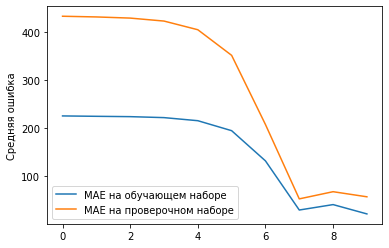

In [47]:
plt.plot(history_3.history['mae'][:], 
         label='MAE на обучающем наборе')
plt.plot(history_3.history['val_mae'][:], 
         label='MAE на проверочном наборе')

plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

In [48]:
pred_3 = model_3.predict(dataset_train).flatten()
pred_val_3 = model_3.predict(dataset_val).flatten()

5/5 [==============================] - 0s 4ms/step


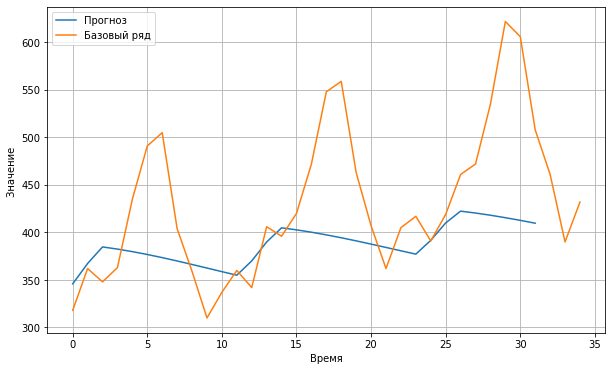

In [49]:
start = 0
step = 100
plt.figure(figsize=(10, 6))
plt.grid('on')
plt.plot(pred_val_3[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

In [50]:
hist_val_3 = history_3.history['val_mae']
hist_train_3 = history_3.history['mae']

Epoch 1/10
13/13 [==============================] - 0s 22ms/step - loss: 833.7927 - mae: 23.6714 - val_loss: 4865.7632 - val_mae: 50.1731
Epoch 2/10
13/13 [==============================] - 0s 22ms/step - loss: 711.5876 - mae: 21.0652 - val_loss: 5802.8149 - val_mae: 54.7811
Epoch 3/10
13/13 [==============================] - 0s 22ms/step - loss: 702.2052 - mae: 21.0239 - val_loss: 5541.8867 - val_mae: 53.4550
Epoch 4/10
13/13 [==============================] - 0s 22ms/step - loss: 700.0591 - mae: 20.9204 - val_loss: 5534.9888 - val_mae: 53.4046
Epoch 5/10
13/13 [==============================] - 0s 22ms/step - loss: 686.8605 - mae: 20.6584 - val_loss: 5523.4092 - val_mae: 53.3175
Epoch 6/10
13/13 [==============================] - 0s 23ms/step - loss: 686.7800 - mae: 20.7203 - val_loss: 5375.0044 - val_mae: 52.5202
Epoch 1/10
13/13 [==============================] - 0s 23ms/step - loss: 680.9989 - mae: 20.6176 - val_loss: 5332.7168 - val_mae: 52.2698
Epoch 2/10
13/13 [================

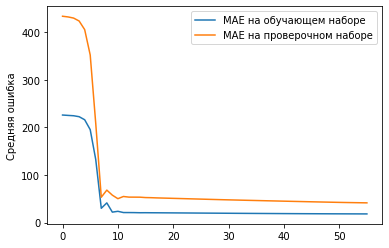

Epoch 1/10
13/13 [==============================] - 0s 22ms/step - loss: 543.3146 - mae: 18.1481 - val_loss: 3431.5398 - val_mae: 41.2209
Epoch 2/10
13/13 [==============================] - 0s 22ms/step - loss: 541.4268 - mae: 18.1156 - val_loss: 3404.8379 - val_mae: 41.0662
Epoch 3/10
13/13 [==============================] - 0s 22ms/step - loss: 539.5953 - mae: 18.0831 - val_loss: 3379.0315 - val_mae: 40.9404
Epoch 4/10
13/13 [==============================] - 0s 22ms/step - loss: 537.8168 - mae: 18.0506 - val_loss: 3354.0884 - val_mae: 40.8167
Epoch 5/10
13/13 [==============================] - 0s 22ms/step - loss: 536.0881 - mae: 18.0181 - val_loss: 3329.9832 - val_mae: 40.6950
Epoch 6/10
13/13 [==============================] - 0s 22ms/step - loss: 534.4053 - mae: 17.9858 - val_loss: 3306.6836 - val_mae: 40.5784
Epoch 7/10
13/13 [==============================] - 0s 23ms/step - loss: 532.7656 - mae: 17.9534 - val_loss: 3284.1570 - val_mae: 40.4785
Epoch 8/10
13/13 [================

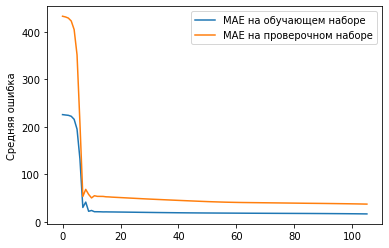

Epoch 1/10
13/13 [==============================] - 0s 23ms/step - loss: 444.0520 - mae: 16.3367 - val_loss: 2543.0461 - val_mae: 36.9605
Epoch 2/10
13/13 [==============================] - 0s 22ms/step - loss: 439.5492 - mae: 16.2503 - val_loss: 2520.5242 - val_mae: 36.8194
Epoch 3/10
13/13 [==============================] - 0s 23ms/step - loss: 434.7719 - mae: 16.1574 - val_loss: 2497.1350 - val_mae: 36.6676
Epoch 4/10
13/13 [==============================] - 0s 23ms/step - loss: 429.7054 - mae: 16.0575 - val_loss: 2472.8298 - val_mae: 36.5043
Epoch 5/10
13/13 [==============================] - 0s 22ms/step - loss: 424.3347 - mae: 15.9501 - val_loss: 2447.5554 - val_mae: 36.3289
Epoch 6/10
13/13 [==============================] - 0s 23ms/step - loss: 418.6460 - mae: 15.8348 - val_loss: 2421.2656 - val_mae: 36.1408
Epoch 7/10
13/13 [==============================] - 0s 23ms/step - loss: 412.6258 - mae: 15.7113 - val_loss: 2393.9106 - val_mae: 35.9525
Epoch 8/10
13/13 [================

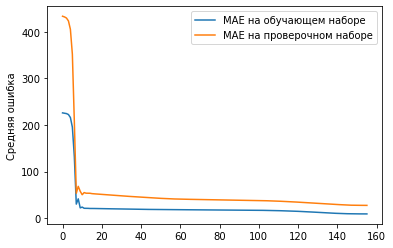

Epoch 1/10
13/13 [==============================] - 0s 22ms/step - loss: 134.9374 - mae: 8.9643 - val_loss: 1052.7202 - val_mae: 27.2739
Epoch 2/10
13/13 [==============================] - 0s 22ms/step - loss: 134.0874 - mae: 8.9522 - val_loss: 1046.0912 - val_mae: 27.2535
Epoch 3/10
13/13 [==============================] - 0s 22ms/step - loss: 133.2949 - mae: 8.9387 - val_loss: 1040.2448 - val_mae: 27.2359
Epoch 4/10
13/13 [==============================] - 0s 22ms/step - loss: 132.5499 - mae: 8.9239 - val_loss: 1035.1288 - val_mae: 27.2211
Epoch 5/10
13/13 [==============================] - 0s 23ms/step - loss: 131.8460 - mae: 8.9078 - val_loss: 1030.6787 - val_mae: 27.2090
Epoch 6/10
13/13 [==============================] - 0s 22ms/step - loss: 131.1766 - mae: 8.8906 - val_loss: 1026.8147 - val_mae: 27.1989
Epoch 7/10
13/13 [==============================] - 0s 22ms/step - loss: 130.5361 - mae: 8.8724 - val_loss: 1023.5088 - val_mae: 27.1909
Epoch 8/10
13/13 [=======================

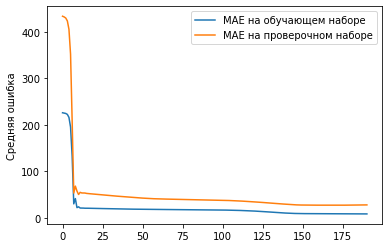

Epoch 1/10
13/13 [==============================] - 0s 22ms/step - loss: 117.6120 - mae: 8.4045 - val_loss: 1066.9669 - val_mae: 27.8479
Epoch 2/10
13/13 [==============================] - 0s 22ms/step - loss: 117.2762 - mae: 8.3896 - val_loss: 1072.0031 - val_mae: 27.8941
Epoch 3/10
13/13 [==============================] - 0s 22ms/step - loss: 116.9451 - mae: 8.3746 - val_loss: 1077.2349 - val_mae: 27.9405
Epoch 4/10
13/13 [==============================] - 0s 22ms/step - loss: 116.6187 - mae: 8.3594 - val_loss: 1082.6576 - val_mae: 27.9871
Epoch 5/10
13/13 [==============================] - 0s 22ms/step - loss: 116.2967 - mae: 8.3442 - val_loss: 1088.2694 - val_mae: 28.0339
Epoch 6/10
13/13 [==============================] - 0s 23ms/step - loss: 115.9793 - mae: 8.3305 - val_loss: 1094.0609 - val_mae: 28.0808
Epoch 1/10
13/13 [==============================] - 0s 22ms/step - loss: 115.6660 - mae: 8.3171 - val_loss: 1100.0315 - val_mae: 28.1614
Epoch 2/10
13/13 [=======================

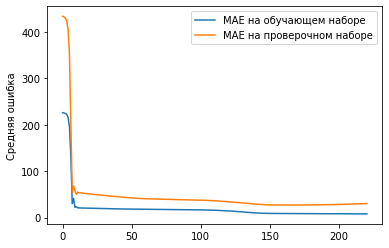

In [51]:
for iteration in range(num_iterations):
  history_3 = model_3.fit(dataset_train,
                      epochs=epochs,
                      validation_data=dataset_val,
                      callbacks=[early_stop])

  hist_val_3.extend(history_3.history['val_mae'][:])
  hist_train_3.extend(history_3.history['mae'][:])

  if (iteration + 1) % 5 == 0:
    plt.plot(hist_train_3, 
            label='MAE на обучающем наборе')
    plt.plot(hist_val_3, 
            label='MAE на проверочном наборе')

    plt.ylabel('Средняя ошибка')
    plt.legend()
    plt.show()

In [52]:
pred_3 = model_3.predict(dataset_train).flatten()
pred_val_3 = model_3.predict(dataset_val).flatten()

5/5 [==============================] - 0s 5ms/step


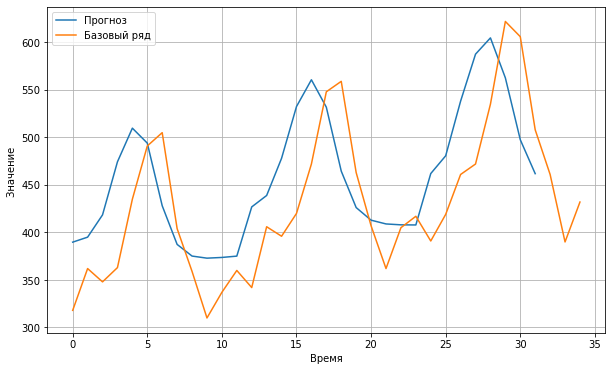

In [53]:
start = 0
step = 100
plt.figure(figsize=(10, 6))
plt.grid('on')
plt.plot(pred_val_3[future + start: future + start + step], 
         label='Прогноз')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

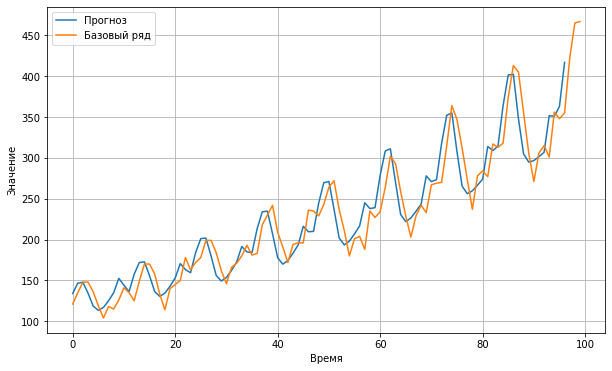

In [54]:
start = 0

plt.figure(figsize=(10, 6))
plt.grid('on')
plt.plot(pred_3[future + start: future + train_size], 
         label='Прогноз')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

In [55]:
train_loss_3, train_m_3 = model_3.evaluate(dataset_train)
test_loss_3, test_m_3 = model_3.evaluate(dataset_val)
print(f'train_loss: {train_loss_3}, train_m: {train_m_3}')
print(f'test_loss: {test_loss_3}, test_m: {test_m_3}')

model.append('GRU')
train_m.append(round(train_m_3,2))
test_m.append(round(test_m_3,2))

5/5 [==============================] - 0s 6ms/step - loss: 1273.3722 - mae: 30.2917
train_loss: 95.14340209960938, train_m: 7.532500743865967
test_loss: 1273.3721923828125, test_m: 30.29168128967285


#### Объединив результаты всех моделей

In [56]:
results['model'] = model
results['train_m'] = train_m
results['test_m'] = test_m

In [57]:
results

,model,train_m,test_m
0,SimpleRNN,20.29,25.99
1,LSTM,7.67,28.68
2,GRU,7.53,30.29


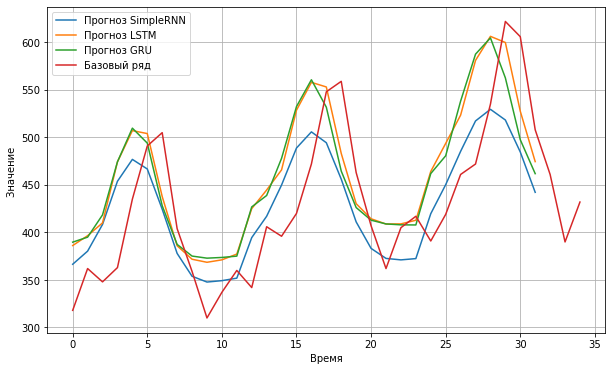

In [58]:
start = 0
step = 100
plt.figure(figsize=(10, 6))
plt.grid('on')
plt.plot(pred_val_1[future + start: future + start + step], 
         label='Прогноз SimpleRNN')
plt.plot(pred_val_2[future + start: future + start + step], 
         label='Прогноз LSTM')
plt.plot(pred_val_3[future + start: future + start + step], 
         label='Прогноз GRU')
plt.plot(y_val.flatten()[start: start+step], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение ')

plt.legend()
plt.show()

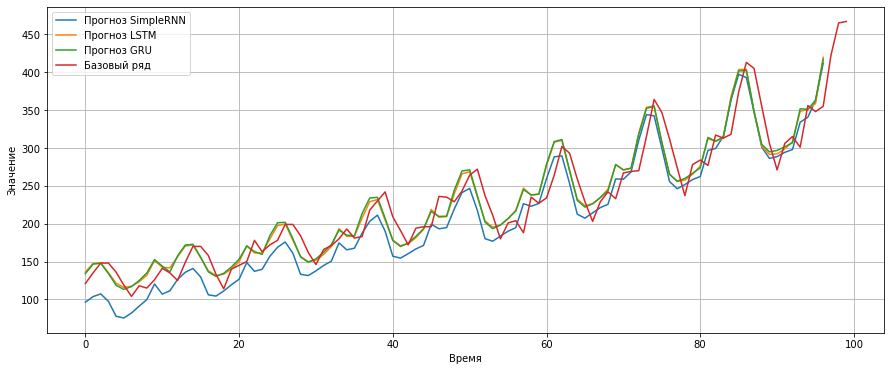

In [59]:
start = 0

plt.figure(figsize=(15, 6))
plt.grid('on')
plt.plot(pred_1[future + start: future + train_size], 
         label='Прогноз SimpleRNN')
plt.plot(pred_2[future + start: future + train_size], 
         label='Прогноз LSTM')
plt.plot(pred_3[future + start: future + train_size], 
         label='Прогноз GRU')
plt.plot(y_train.flatten()[start: train_size], 
         label='Базовый ряд')
plt.xlabel('Время')
plt.ylabel('Значение')
plt.legend()
plt.show()

### Вывод:<br>
- чем больше итераций - тем выше качество (можно поставить 25)
- для данного датасета лучше справился SimpleRNN, GRU и LSTM показали похожий результат именно на валидации